In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.3.0


In [3]:
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_pred = linear_model(x)
    loss = mse_loss(y_pred, y)
  gradients = tape.gradient(loss, [W, b])
  optimizer.apply_gradients(zip(gradients, [W, b]))

## 그래디언트 테이프
텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것)을 위한 tf.GradientTape API를 제공합니다. tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"합니다. 그 다음 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 테이프에 "기록된" 연산의 그래디언트를 계산합니다.

In [4]:
# 선형회귀 모델(Wx + b)을 위한 tf.Variable을 선언합니다 = 난수
W = tf.Variable(tf.random.normal(shape=[1]))
b = tf.Variable(tf.random.normal(shape=[1]))

@tf.function # <-- 텐서플로우의 그래프로 그려질 함수라고 정의
def linear_model(x): # 모델 선언
  return W*x + b

# 손실 함수를 정의합니다.
# MSE 손실함수 \mean{(y' - y)^2} 예측치에서 결과값을 빼고 제곱을 한뒤 모두 더하고 평균을 구함
@tf.function
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y)) # tf.square = 제곱

# 최적화를 위한 그라디언트 디센트 옵티마이저를 정의합니다.
optimizer = tf.optimizers.SGD(0.01)# SGD = Stochastic Gradient Descent / 기울기가 0에 가까워 질 때 까지 0.01만큼씩 움직인다

# 최적화를 위한 function을 정의합니다.
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_pred = linear_model(x)
    loss = mse_loss(y_pred, y)
  gradients = tape.gradient(loss, [W, b])
  optimizer.apply_gradients(zip(gradients, [W, b]))

# 트레이닝을 위한 입력값과 출력값을 준비합니다.
x_train = [1, 2, 3, 4]# y = 2x
y_train = [2, 4, 6, 8]

# 경사하강법을 1000번 수행합니다.
for i in range(1000):
  train_step(x_train, y_train)

# 테스트를 위한 입력값을 준비합니다.
x_test = [3.5, 5, 5.5, 6]
# 테스트 데이터를 이용해 학습된 선형회귀 모델이 데이터의 경향성(y=2x)을 잘 학습했는지 측정합니다.
# 예상되는 참값 : [7, 10, 11, 12]
print(linear_model(x_test).numpy())

[ 6.9962645  9.986257  10.982921  11.979585 ]


In [5]:
print(W.numpy(),b.numpy())

[1.9933281] [0.01961622]


## mnist_classification_using_ann
### 텐서플로우를 이용한 ANN(Artificial Neural Networks) 구현


In [6]:
# -*- coding: utf-8 -*-
# 텐서플로우를 이용한 ANN(Artificial Neural Networks) 구현

import tensorflow as tf
# MNIST 데이터를 다운로드 합니다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [7]:
print(x_train.shape) # x_train의 차수
print(y_train.shape) # y_train의 차수

(60000, 28, 28)
(60000,)


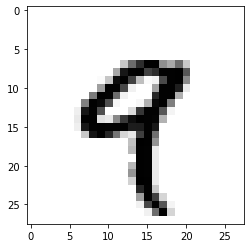

In [8]:
import matplotlib.pyplot as plt

digit = x_train[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [9]:
# MNIST 데이터를 다운로드 합니다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 이미지들을 float32 데이터 타입으로 변경합니다.
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
# 28*28 형태의 이미지를 784차원으로 flattening 합니다.
x_train, x_test = x_train.reshape([-1, 28*28]), x_test.reshape([-1, 28*28]) # 28*28 = data.shape
# [0, 255] 사이의 값을 [0, 1]사이의 값으로 Normalize합니다.
x_train, x_test = x_train / 255., x_test / 255.


위 코드를 실행하니 2차함수로 바뀌었다

In [10]:
print(x_train.shape) # x_train의 차수
print(y_train.shape) # y_train의 차수

(60000, 784)
(60000,)


In [11]:
# 레이블 데이터에 one-hot encoding을 적용합니다.
y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)

In [12]:
print(x_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
# 학습을 위한 설정값들을 정의합니다.
learning_rate = 0.001
num_epochs = 30     # 학습횟수
batch_size = 256    # 배치개수 = mini batch
display_step = 1    # 손실함수 출력 주기
input_size = 784    # 28 * 28
hidden1_size = 256
hidden2_size = 256
output_size = 10

# tf.data API를 이용해서 데이터를 섞고 batch 형태로 가져옵니다.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(60000).batch(batch_size)

In [14]:
# ANN 모델을 정의합니다.
class ANN(object):
  # ANN 모델을 위한 tf.Variable들을 정의합니다.
  def __init__(self):
    self.W1 = tf.Variable(tf.random.normal(shape=[input_size, hidden1_size]))
    self.b1 = tf.Variable(tf.random.normal(shape=[hidden1_size]))
    self.W2 = tf.Variable(tf.random.normal(shape=[hidden1_size, hidden2_size]))
    self.b2 = tf.Variable(tf.random.normal(shape=[hidden2_size]))
    self.W_output = tf.Variable(tf.random.normal(shape=[hidden2_size, output_size]))
    self.b_output = tf.Variable(tf.random.normal(shape=[output_size]))

  def __call__(self, x):
    H1_output = tf.nn.relu(tf.matmul(x, self.W1) + self.b1)
    H2_output = tf.nn.relu(tf.matmul(H1_output, self.W2) + self.b2)
    logits = tf.matmul(H2_output, self.W_output) + self.b_output

    return logits

In [15]:
# cross-entropy 손실 함수를 정의합니다.
@tf.function
def cross_entropy_loss(logits, y):
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# 최적화를 위한 Adam 옵티마이저를 정의합니다.
optimizer = tf.optimizers.Adam(learning_rate)


In [16]:
# 최적화를 위한 function을 정의합니다.
@tf.function
def train_step(model, x, y):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = cross_entropy_loss(y_pred, y)
  gradients = tape.gradient(loss, vars(model).values())
  optimizer.apply_gradients(zip(gradients, vars(model).values()))

# 모델의 정확도를 출력하는 함수를 정의합니다.
@tf.function
def compute_accuracy(y_pred, y):
  correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

  return accuracy

In [17]:
# ANN 모델을 선언합니다.
ANN_model = ANN()

# 지정된 횟수만큼 최적화를 수행합니다.
for epoch in range(num_epochs):
  average_loss = 0.
  total_batch = int(x_train.shape[0] / batch_size)
  # 모든 배치들에 대해서 최적화를 수행합니다.
  for batch_x, batch_y in train_data:
    # 옵티마이저를 실행해서 파라마터들을 업데이트합니다.
    _, current_loss = train_step(ANN_model, batch_x, batch_y), cross_entropy_loss(ANN_model(batch_x), batch_y)
    # 평균 손실을 측정합니다.
    average_loss += current_loss / total_batch
  # 지정된 epoch마다 학습결과를 출력합니다.
  if epoch % display_step == 0:
    print("반복(Epoch): %d, 손실 함수(Loss): %f" % ((epoch+1), average_loss))

# 테스트 데이터를 이용해서 학습된 모델이 얼마나 정확한지 정확도를 출력합니다.
print("정확도(Accuracy): %f" % compute_accuracy(ANN_model(x_test), y_test)) # 정확도: 약 94%

반복(Epoch): 1, 손실 함수(Loss): 313.931702
반복(Epoch): 2, 손실 함수(Loss): 66.463295
반복(Epoch): 3, 손실 함수(Loss): 43.026741
반복(Epoch): 4, 손실 함수(Loss): 31.443716
반복(Epoch): 5, 손실 함수(Loss): 24.411131
반복(Epoch): 6, 손실 함수(Loss): 19.539080
반복(Epoch): 7, 손실 함수(Loss): 15.980289
반복(Epoch): 8, 손실 함수(Loss): 13.105030
반복(Epoch): 9, 손실 함수(Loss): 10.834544
반복(Epoch): 10, 손실 함수(Loss): 8.986451
반복(Epoch): 11, 손실 함수(Loss): 7.505862
반복(Epoch): 12, 손실 함수(Loss): 6.222371
반복(Epoch): 13, 손실 함수(Loss): 5.203405
반복(Epoch): 14, 손실 함수(Loss): 4.190659
반복(Epoch): 15, 손실 함수(Loss): 3.450699
반복(Epoch): 16, 손실 함수(Loss): 2.828998
반복(Epoch): 17, 손실 함수(Loss): 2.261593
반복(Epoch): 18, 손실 함수(Loss): 1.821124
반복(Epoch): 19, 손실 함수(Loss): 1.379524
반복(Epoch): 20, 손실 함수(Loss): 1.088873
반복(Epoch): 21, 손실 함수(Loss): 0.829770
반복(Epoch): 22, 손실 함수(Loss): 0.617871
반복(Epoch): 23, 손실 함수(Loss): 0.540465
반복(Epoch): 24, 손실 함수(Loss): 0.381158
반복(Epoch): 25, 손실 함수(Loss): 0.308026
반복(Epoch): 26, 손실 함수(Loss): 0.241563
반복(Epoch): 27, 손실 함수(Loss): 0.163131
